In [1]:
import pandas as pd 
from pandas import Series
import numpy as np 
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.api import qqplot  
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.stattools import durbin_watson


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 

import pmdarima as pm
from pmdarima import auto_arima 
from pmdarima.model_selection import train_test_split
from pmdarima.arima.utils import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn import datasets

# Ignore harmless warnings 
import warnings 
warnings.filterwarnings("ignore") 

In [25]:
#Importing data
Beijing = pd.read_csv("D:/Math546 Time series/final projects/PM2.5 Data of Five Chinese Cities Data Set/BeijingPM20100101_20151231.csv")

In [26]:
#Delet non-useful data
Beijing.drop(['PM_Dongsi', 'PM_Dongsihuan', 'PM_Nongzhanguan', 'season', 'precipitation', 'Iprec'], 
               axis=1,
              inplace=True)

In [27]:
Beijing.dropna(axis=0, how="any",inplace=True)

In [28]:
# from datetime import datetime
Beijing['Time'] = pd.to_datetime(Beijing['year'].map(str) +"/"+ Beijing['month'].map(str) +"/"+ Beijing['day'].map(str)+" "+Beijing['hour'].map(str)+":00:00")
#Beijing

In [13]:
#Beijing.groupby(['year']).size()

In [29]:
by_hour = Beijing.groupby(['Time']).mean()
print(by_hour.head())

                     No  year  month  day  hour  PM_US Post  DEWP  HUMI  \
Time                                                                      
2010-01-01 23:00:00  24  2010      1    1    23       129.0 -17.0  41.0   
2010-01-02 00:00:00  25  2010      1    2     0       148.0 -16.0  38.0   
2010-01-02 01:00:00  26  2010      1    2     1       159.0 -15.0  42.0   
2010-01-02 02:00:00  27  2010      1    2     2       181.0 -11.0  63.5   
2010-01-02 03:00:00  28  2010      1    2     3       138.0  -7.0  85.0   

                       PRES  TEMP   Iws  
Time                                     
2010-01-01 23:00:00  1020.0  -5.0  0.89  
2010-01-02 00:00:00  1020.0  -4.0  1.79  
2010-01-02 01:00:00  1020.0  -4.0  2.68  
2010-01-02 02:00:00  1021.0  -5.0  3.57  
2010-01-02 03:00:00  1022.0  -5.0  5.36  


In [32]:
by_hour.index = pd.to_datetime(by_hour.index, 
                             format='%d-%m-%Y %H:%M:%S')
by_hour = by_hour.set_index(by_hour.index).asfreq('H')
by_hour = by_hour.fillna(method='ffill')

print(by_hour.index)

DatetimeIndex(['2010-01-01 23:00:00', '2010-01-02 00:00:00',
               '2010-01-02 01:00:00', '2010-01-02 02:00:00',
               '2010-01-02 03:00:00', '2010-01-02 04:00:00',
               '2010-01-02 05:00:00', '2010-01-02 06:00:00',
               '2010-01-02 07:00:00', '2010-01-02 08:00:00',
               ...
               '2015-12-31 14:00:00', '2015-12-31 15:00:00',
               '2015-12-31 16:00:00', '2015-12-31 17:00:00',
               '2015-12-31 18:00:00', '2015-12-31 19:00:00',
               '2015-12-31 20:00:00', '2015-12-31 21:00:00',
               '2015-12-31 22:00:00', '2015-12-31 23:00:00'],
              dtype='datetime64[ns]', name='Time', length=52561, freq='H')


In [33]:
by_hour['Time'] = by_hour.index
by_hour['Time']

Time
2010-01-01 23:00:00   2010-01-01 23:00:00
2010-01-02 00:00:00   2010-01-02 00:00:00
2010-01-02 01:00:00   2010-01-02 01:00:00
2010-01-02 02:00:00   2010-01-02 02:00:00
2010-01-02 03:00:00   2010-01-02 03:00:00
                              ...        
2015-12-31 19:00:00   2015-12-31 19:00:00
2015-12-31 20:00:00   2015-12-31 20:00:00
2015-12-31 21:00:00   2015-12-31 21:00:00
2015-12-31 22:00:00   2015-12-31 22:00:00
2015-12-31 23:00:00   2015-12-31 23:00:00
Freq: H, Name: Time, Length: 52561, dtype: datetime64[ns]

In [71]:
data_13 = by_hour[(by_hour['Time'] >=pd.to_datetime('20130101030000')) & (by_hour['Time'] <= pd.to_datetime('20150101030000'))]

In [72]:
data_13 = data_13.set_index(data_13.index).asfreq('d')
data_13

,No,year,month,day,hour,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws,Time
Time,,,,,,,,,,,,
2013-01-01 03:00:00,26308.0,2013.0,1.0,1.0,3.0,16.0,-14.0,72.0,1018.0,-10.0,14.75,2013-01-01 03:00:00
2013-01-02 03:00:00,26332.0,2013.0,1.0,2.0,3.0,17.0,-28.0,25.0,1035.0,-12.0,156.03,2013-01-02 03:00:00
2013-01-03 03:00:00,26356.0,2013.0,1.0,3.0,3.0,20.0,-28.0,25.0,1046.0,-12.0,375.07,2013-01-03 03:00:00
2013-01-04 03:00:00,26380.0,2013.0,1.0,4.0,3.0,56.0,-22.0,65.0,1038.0,-17.0,20.13,2013-01-04 03:00:00
2013-01-05 03:00:00,26404.0,2013.0,1.0,5.0,3.0,78.0,-22.0,50.0,1028.0,-14.0,3.13,2013-01-05 03:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
2014-12-28 03:00:00,43732.0,2014.0,12.0,28.0,3.0,334.0,-9.0,63.0,1023.0,-3.0,6.26,2014-12-28 03:00:00
2014-12-29 03:00:00,43756.0,2014.0,12.0,29.0,3.0,318.0,-11.0,67.0,1015.0,-6.0,6.68,2014-12-29 03:00:00
2014-12-30 03:00:00,43780.0,2014.0,12.0,30.0,3.0,25.0,-13.0,42.0,1017.0,-2.0,10.73,2014-12-30 03:00:00


In [73]:
by_hour

,No,year,month,day,hour,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws,Time
Time,,,,,,,,,,,,
2010-01-01 23:00:00,24.0,2010.0,1.0,1.0,23.0,129.0,-17.0,41.0,1020.0,-5.0,0.89,2010-01-01 23:00:00
2010-01-02 00:00:00,25.0,2010.0,1.0,2.0,0.0,148.0,-16.0,38.0,1020.0,-4.0,1.79,2010-01-02 00:00:00
2010-01-02 01:00:00,26.0,2010.0,1.0,2.0,1.0,159.0,-15.0,42.0,1020.0,-4.0,2.68,2010-01-02 01:00:00
2010-01-02 02:00:00,27.0,2010.0,1.0,2.0,2.0,181.0,-11.0,63.5,1021.0,-5.0,3.57,2010-01-02 02:00:00
2010-01-02 03:00:00,28.0,2010.0,1.0,2.0,3.0,138.0,-7.0,85.0,1022.0,-5.0,5.36,2010-01-02 03:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-31 19:00:00,52580.0,2015.0,12.0,31.0,19.0,133.0,-8.0,68.0,1031.0,-3.0,7.14,2015-12-31 19:00:00
2015-12-31 20:00:00,52581.0,2015.0,12.0,31.0,20.0,169.0,-8.0,63.0,1030.0,-2.0,8.03,2015-12-31 20:00:00
2015-12-31 21:00:00,52582.0,2015.0,12.0,31.0,21.0,203.0,-10.0,73.0,1030.0,-6.0,0.89,2015-12-31 21:00:00


In [74]:
data = by_hour[(by_hour['Time'] >=pd.to_datetime('20130101030000')) & (by_hour['Time'] <= pd.to_datetime('20130112030000'))]
data = data.set_index(data.index).asfreq('H')
data

,No,year,month,day,hour,PM_US Post,DEWP,HUMI,PRES,TEMP,Iws,Time
Time,,,,,,,,,,,,
2013-01-01 03:00:00,26308.0,2013.0,1.0,1.0,3.0,16.0,-14.0,72.0,1018.0,-10.0,14.75,2013-01-01 03:00:00
2013-01-01 04:00:00,26309.0,2013.0,1.0,1.0,4.0,15.0,-15.0,66.0,1018.0,-10.0,0.45,2013-01-01 04:00:00
2013-01-01 05:00:00,26310.0,2013.0,1.0,1.0,5.0,9.0,-15.0,78.0,1019.0,-12.0,3.13,2013-01-01 05:00:00
2013-01-01 06:00:00,26311.0,2013.0,1.0,1.0,6.0,9.0,-15.0,72.0,1020.0,-11.0,0.89,2013-01-01 06:00:00
2013-01-01 07:00:00,26312.0,2013.0,1.0,1.0,7.0,7.0,-16.0,45.0,1020.0,-6.0,4.92,2013-01-01 07:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...
2013-01-11 23:00:00,26568.0,2013.0,1.0,11.0,23.0,374.0,-8.0,79.0,1025.0,-5.0,3.13,2013-01-11 23:00:00
2013-01-12 00:00:00,26569.0,2013.0,1.0,12.0,0.0,391.0,-10.0,92.0,1025.0,-9.0,0.89,2013-01-12 00:00:00
2013-01-12 01:00:00,26570.0,2013.0,1.0,12.0,1.0,442.0,-11.0,92.0,1025.0,-10.0,1.79,2013-01-12 01:00:00


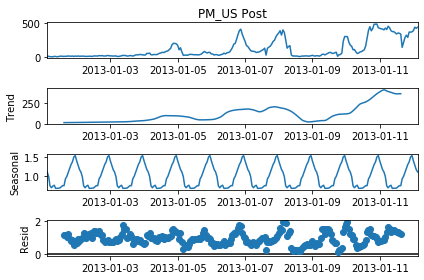

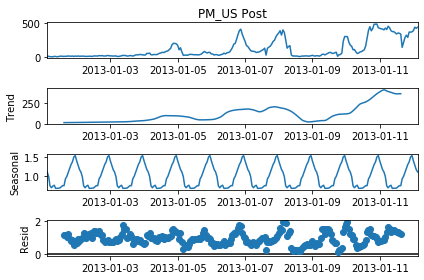

In [75]:
result = seasonal_decompose(data['PM_US Post'],  
                            model ='multiplicative') 
  
# ETS plot  
result.plot()

In [76]:
len(data_13)

731

In [86]:
# Split data into train / test sets 
train = data_13['PM_US Post'].iloc[:len(data_13)-156] 
test = data_13['PM_US Post'].iloc[len(data_13)-156:]

In [87]:
# Fit auto_arima function to dataset 
stepwise_fit = auto_arima(train, start_p = 0, start_q = 0, 
                          max_p = 4, max_q = 4, m=7,
                          start_P = 0, 
                          d = None, D = 1, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)           # set to stepwise  

Performing stepwise search to minimize aic
Fit ARIMA: (0, 0, 0)x(0, 1, 1, 7) (constant=True); AIC=6882.951, BIC=6895.978, Time=0.451 seconds
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 7) (constant=True); AIC=7209.604, BIC=7218.288, Time=0.026 seconds
Fit ARIMA: (1, 0, 0)x(1, 1, 0, 7) (constant=True); AIC=6927.766, BIC=6945.135, Time=0.360 seconds
Fit ARIMA: (0, 0, 1)x(0, 1, 1, 7) (constant=True); AIC=6769.598, BIC=6786.967, Time=0.397 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: (0, 0, 0)x(0, 1, 0, 7) (constant=False); AIC=7207.616, BIC=7211.958, Time=0.016 seconds
Fit ARIMA: (0, 0, 0)x(1, 1, 1, 7) (constant=True); AIC=6882.609, BIC=6899.977, Time=0.397 seconds
Near non-invertible roots for order (0, 0, 0)(1, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.999)
Fit ARIMA: (0, 0, 0)x(0, 1, 2, 7) (constant=True); A

In [88]:
# To print the summary 
stepwise_fit.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  575
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -3376.311
Date:                           Fri, 10 Apr 2020   AIC                           6762.622
Time:                                   18:10:17   BIC                           6784.333
Sample:                                        0   HQIC                          6771.094
                                           - 575                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.1869      0.254     -0.735      0.462      -0.685       0.311
ar.L1          0.2894      0.078      3.722      0.000       0.137       0.442
ma.L1          0.1844      0.087      2.129      0.033       0.015       0.354
ma.S.L7       -0.9996      0.886     -1.128      0.259      -2.736       0.737
sigma2      8074.0540   7091.816      1.139      0.255   -5825.650     2.2e+04
===================================================================================
Ljung-Box (Q):                       62.13   Jarque-Bera (JB):               384.30
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             1.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [89]:
# Fit a SARIMAX(1, 0, 1)x(0, 1, [1], 7)on the training set 
from statsmodels.tsa.statespace.sarimax import SARIMAX 
  
model = SARIMAX(train,  
                order = (1, 0, 0),  
                seasonal_order =(0, 1, 1, 7))

In [90]:
result = model.fit() 

In [91]:
 result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          PM_US Post   No. Observations:                  575
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -3378.646
Date:                             Fri, 10 Apr 2020   AIC                           6763.293
Time:                                     18:10:21   BIC                           6776.319
Sample:                                 01-01-2013   HQIC                          6768.376
                                      - 07-29-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4399      0.025     17.341      0.000       0.390       0.490
ma.S.L7       -0.9991      0.480     -2.083      0.037      -1.939      -0.059
sigma2      8144.2456   3854.266      2.113      0.035     590.024    1.57e+04
===================================================================================
Ljung-Box (Q):                       69.07   Jarque-Bera (JB):               398.45
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.63   Skew:                             1.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

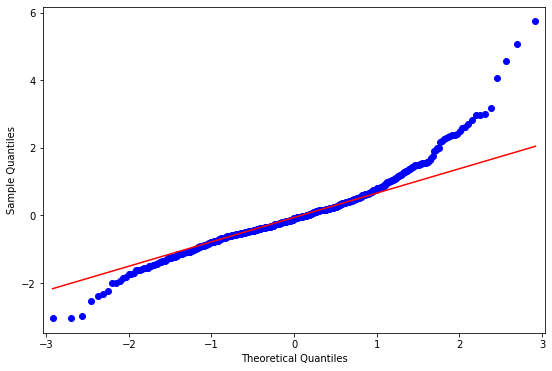

In [92]:
resid = result.resid
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
qqplot(resid, line='q', ax=ax, fit=True)
plt.show()

In [93]:
len(data_13)

731

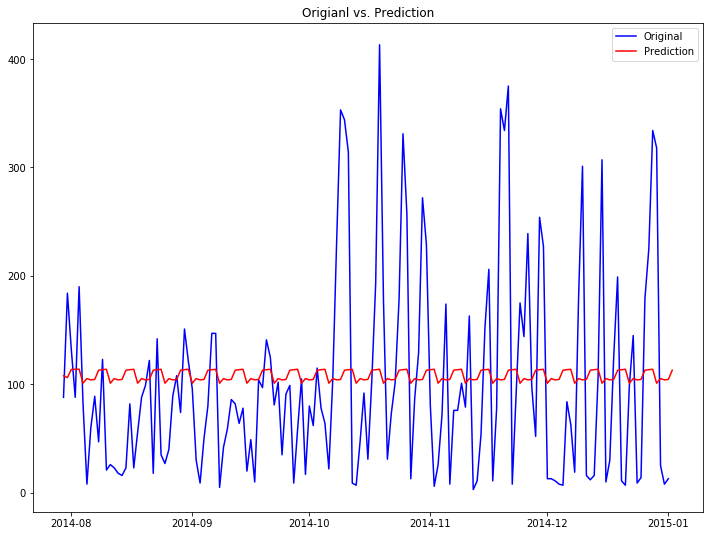

In [95]:
predict_ARMA = result.predict(start =575, end = 731) 
#print(predict_ARIMA) 

plt.figure(figsize=(12,9)) 
orig = plt.plot(test, color='blue', label='Original') 
pred = plt.plot(predict_ARMA, color='red', label='Prediction' ) 
plt.legend(loc='best') 
plt.title('Origianl vs. Prediction') 
plt.show(block=False) 